In [1]:
#TO RE-RUN
%reset -f

In [2]:
from sklearn import preprocessing
from time import time
import numpy as np
import csv
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE,ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

from operator import truediv
from sklearn import metrics
import pandas as pd
import time
import os

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('classic')

%matplotlib inline

import sys
sys.path.insert(1, "/home/ilmira/healthforecast/readmission/src/")
from TypeFeatImputer import TypeFeatImputer
from UnivCombineFilter import UnivCombineFilter

/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
#df_all=pd.read_csv(os.path.join('resources','diabetic_data_processed_withweight.csv'),';')
df_all=pd.read_pickle(os.path.join('resources','clean_data_hyp_1.pkl'))
print df_all.shape
print df_all.columns
print df_all.readmitted.value_counts()
print df_all.readmitted.value_counts()/float(df_all.shape[0])

(71518, 20)
Index([u'diss_1', u'race_AfricanAmerican', u'race_Caucasian', u'race_Other',
       u'medSpec_cardio', u'medSpec_Family/GeneralPractice',
       u'medSpec_InternalMedicine', u'medSpec_surgery', u'age_cat',
       u'Diabetis', u'Circulatory', u'Digestive', u'Genitourinary',
       u'Poisoning', u'Muscoskeletal', u'Neoplasms', u'Respiratory', u'HbA1c',
       u'Change', u'readmitted'],
      dtype='object')
0    42985
2    22240
1     6293
Name: readmitted, dtype: int64
0   0.60
2   0.31
1   0.09
Name: readmitted, dtype: float64


#### Compute class label

In [4]:
print df_all.loc[:,"readmitted"].sort_values().unique(), np.sum(df_all["readmitted"] == 0), np.sum(df_all["readmitted"] == 1), np.sum(df_all["readmitted"] == 2)

[0 1 2] 42985 6293 22240


In [11]:
# Readmitted none vs readmitted
df_all["readmitted"][df_all["readmitted"].values > 0] = 1
print df_all.iloc[:,-1].sort_values().unique(), np.sum(df_all["readmitted"] == 0), np.sum(df_all["readmitted"] == 1)

[0 1 2] 42985 6293 22240
[0 1] 42985 28533


/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# Readmitted none vs early readmitted
df_all= df_all[df_all["readmitted"].isin([0,1])]
print df_all.iloc[:,-1].sort_values().unique(), np.sum(df_all["readmitted"] == 0), np.sum(df_all["readmitted"] == 1)

[0 1] 42985 6293


#### Compute type fields

In [6]:
numCols = []
catCols = []
cols = df_all.columns
reducedCols = cols[:-1]

for i in range(len(cols)-1):
    if cols[i] not in numCols:
        catCols.append(1)
    else:
        catCols.append(0)
catCols = np.array(catCols)

print "Cat cols:", np.sum(catCols==1), "\n", reducedCols[catCols==1]
print "Num cols:", np.sum(catCols==0), "\n", reducedCols[catCols==0]
print len(reducedCols)

Cat cols: 19 
Index([u'diss_1', u'race_AfricanAmerican', u'race_Caucasian', u'race_Other',
       u'medSpec_cardio', u'medSpec_Family/GeneralPractice',
       u'medSpec_InternalMedicine', u'medSpec_surgery', u'age_cat',
       u'Diabetis', u'Circulatory', u'Digestive', u'Genitourinary',
       u'Poisoning', u'Muscoskeletal', u'Neoplasms', u'Respiratory', u'HbA1c',
       u'Change'],
      dtype='object')
Num cols: 0 
Index([], dtype='object')
19


#### Compute partition (train, test)

In [7]:
y = df_all.readmitted
print y.unique()
print y.value_counts()
y = y.values

X = df_all.iloc[:,:-1].values
sss = StratifiedShuffleSplit(y, 1, test_size=0.30, random_state=32) #random_state=42
for train_index, test_index in sss:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print
print X_train.shape, y_train.shape
print np.sum(y_train == 0), round(np.sum(y_train == 0)/float(y_train.shape[0]),2), \
      np.sum(y_train > 0), round(np.sum(y_train > 0)/float(y_train.shape[0]),2)
print X_test.shape, y_test.shape
print np.sum(y_test == 0), round(np.sum(y_test == 0)/float(y_test.shape[0]),2), \
      np.sum(y_test > 0), round(np.sum(y_test > 0)/float(y_test.shape[0]),2)


[1 0]
0    42985
1     6293
Name: readmitted, dtype: int64

(34494, 19) (34494,)
30089 0.87 4405 0.13
(14784, 19) (14784,)
12896 0.87 1888 0.13


#### Simple pipeline

In [31]:
basePipeline = Pipeline([
        ("Imputer", TypeFeatImputer(catCols, reducedCols)),
        ("Variance", VarianceThreshold(threshold=(.995 * (1 - .995)))),
        ("Scaler", StandardScaler())
    ])

params = {}
pipeline = []
pipe = Pipeline(list(basePipeline.steps))

In [131]:
fs_method = "combine_fs"
pipe.steps.insert(1,(fs_method, UnivCombineFilter(catCols,np.array(reducedCols))))
params.update({fs_method + '__percentile':[30,50,70,80]})

In [32]:
cls_method = "logReg"
pipe.steps.append((cls_method, LogisticRegression(random_state=42)))
params.update({cls_method + '__C': [1e-8,1e-6,1e-5,0.001,0.01,0.1,1,5,10]})
params.update({cls_method + '__class_weight': [None, 'balanced']})
params.update({cls_method + '__penalty': ["l1","l2"]})

In [111]:
cls_method = "rf"
pipe.steps.append((cls_method, RandomForestClassifier(n_jobs=-1,random_state=42,class_weight="balanced")))
params.update({cls_method + '__n_estimators': [150,300,500,700], 
               cls_method + '__criterion': ['gini'],
               cls_method + '__max_depth' : [None,4,6,8,10]})

In [302]:
cls_method = "knn"
pipe.steps.append((cls_method, KNeighborsClassifier(n_jobs=-1)))

params.update({cls_method + '__n_neighbors': [3,5,7,9], 
               cls_method + '__weights': ['uniform', 'distance']})

In [419]:
cls_method = "svm"
pipe.steps.append((cls_method, SVC(kernel = "rbf", random_state=42,probability=True)))
params.update({cls_method + '__C': [0.01,0.1,0.5,1,5,10,15,30,50], 
               cls_method + '__gamma' : [0.0001,0.001,0.01, 0.1,1,5],
               cls_method + '__class_weight': [None, 'balanced']})

In [47]:
cls_method = "nb"
pipe.steps.append((cls_method, GaussianNB()))
#params.update({cls_method + '__alpha': [1e-3,0.001,0.01,0.1,0.5,1,5]})

In [33]:
#Post process pipeline
pipe_imb = make_pipeline(*[p[1] for p in pipe.steps])
stps = len(pipe_imb.steps)        
for s in range(stps):
    pipe_imb.steps.remove(pipe_imb.steps[0])
for s in range(stps):
    pipe_imb.steps.append(pipe.steps[s])

In [34]:
#Add sampling
sm_method = "smote"                
pipe_imb.steps.insert(stps - 1, 
                      (sm_method, SMOTE(ratio='auto', kind='regular', random_state=32)))
params.update({sm_method + "__k_neighbors":[3,4,5]})

#### Pipeline setup

In [34]:
verbose = False
mtrs = ["f1_weighted","recall"] #"f1","recall","precision"
cv_thr = 0.3
cv_folds = 5

print pipe_imb.steps

[('Imputer', TypeFeatImputer(allNameCols=Index([u'diss_1', u'race_AfricanAmerican', u'race_Caucasian', u'race_Other',
       u'medSpec_cardio', u'medSpec_Family/GeneralPractice',
       u'medSpec_InternalMedicine', u'medSpec_surgery', u'age_cat',
       u'Diabetis', u'Circulatory', u'Digestive', u'Genitourinary',
       u'Poisoning', u'Muscoskeletal', u'Neoplasms', u'Respiratory', u'HbA1c',
       u'Change'],
      dtype='object'),
        dataCatCols=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))), ('Variance', VarianceThreshold(threshold=0.004975)), ('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logReg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]


#### Run pipeline

In [ ]:
print "ALL TRAIN:", X_train.shape
print "TRAIN:", "[0's:", np.sum(y_train==0), "1's:", np.sum(y_train==1), "]"
print "ALL TEST:", X_test.shape
print "TEST:", "[0's:", np.sum(y_test==0), "1's:", np.sum(y_test==1), "]"
print "TEST:", "[0's:", np.sum(y_test==0)/float(y_test.shape[0]), "1's:", np.sum(y_test==1)/float(y_test.shape[0]), "]"

# Run experiment
start = time.time()

#Prepare pipe_cls      
pipeline_cls = pipe_imb
pipeline_params = params

if verbose:
    print "\n",pipeline_cls.steps


#Prepare cv
cv_inner = StratifiedShuffleSplit(y_train, n_iter=cv_folds, test_size=cv_thr,random_state=24)

print "\nCV TRAIN:", cv_inner.n_train
print "CV_TEST:", cv_inner.n_test

#Fit pipeline with CV                        
grid_pipelines = []

for m in mtrs:
    grid_pipeline = GridSearchCV(pipeline_cls, param_grid=pipeline_params, verbose=1, 
                                 n_jobs=-1, cv=cv_inner, scoring= m, error_score = 0,
                                 refit=True) 
    grid_pipeline.fit(X_train, y_train)
    grid_pipelines.append([m,grid_pipeline])

end = time.time()
print "Total time:", end - start

ALL TRAIN: (34494, 19)
TRAIN: [0's: 30089 1's: 4405 ]
ALL TEST: (14784, 19)
TEST: [0's: 12896 1's: 1888 ]
TEST: [0's: 0.872294372294 1's: 0.127705627706 ]

CV TRAIN: 24145
CV_TEST: 10349
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    4.3s


In [26]:
for gp in grid_pipelines:
    print
    print gp[0]
    print "*****\n"
    print gp[1].best_estimator_.steps[-1]
    print
    
    if gp[1].best_estimator_.steps[1][0] == "combine_fs":
        varFilter = gp[1].best_estimator_.steps[1][1]

        print "Selected thr:", varFilter.percentile
        print "Selected columns:"
        feats = reducedCols[varFilter.ixCols].tolist()
        print feats
        print "Num useful features:", len(feats), feats
    
    if gp[1].best_estimator_.steps[1][0] == "Variance":
        varFilter = gp[1].best_estimator_.steps[1][1]
        feats = reducedCols[varFilter.get_support() == False]
        print "Discarded feats:", len(feats), feats


f1_weighted
*****

('logReg', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))

Discarded feats: 0 Index([], dtype='object')

recall
*****

('logReg', LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))

Discarded feats: 0 Index([], dtype='object')


In [27]:
# Computel Train score (with best CV params)
for gp in grid_pipelines:
    
    cls = gp[1]
    y_pred = cls.predict(X_train)                
    train_prec_scores = metrics.precision_score(y_train, y_pred, average='weighted', pos_label=None)
    train_rec_scores = metrics.recall_score(y_train, y_pred, average='weighted', pos_label=None)
    train_f1_scores = metrics.f1_score(y_train, y_pred, average='weighted', pos_label=None)

    print "\nTRAIN: "
    print "**********\n"

    print "Metric:",gp[0]
    print "TR Prec score:", train_prec_scores
    print "TR Rec score:", train_rec_scores
    print "TR F1 score:", train_f1_scores


TRAIN: 
**********

Metric: f1_weighted
TR Prec score: 0.760901412974
TR Rec score: 0.872296631298
TR F1 score: 0.812800066244

TRAIN: 
**********

Metric: recall
TR Prec score: 0.80972382947
TR Rec score: 0.560851162521
TR F1 score: 0.633207840783


In [28]:
# Compute pipeline evaluation with CV
for gp in grid_pipelines:
    
    cls = gp[1]
    print "\nCV: "
    print "******\n"
    
    print "Metric:", gp[0]
    print "CV selected params {}".format(cls.best_params_.values())
    cv_inner_f1 = cross_val_score(cls.best_estimator_, X_train, y_train, 
                                             cv=cv_inner, scoring='f1_weighted', n_jobs=-1)
    print "CV {} score: {}".format(gp[0], cls.best_score_)
    print "CV f1 score: %0.3f  (+/-%0.03f)" % (np.mean(cv_inner_f1), np.std(cv_inner_f1))


CV: 
******

Metric: f1_weighted
CV selected params [None, 1e-05, 'l1']
CV f1_weighted score: 0.812745114975
CV f1 score: 0.813  (+/-0.000)

CV: 
******

Metric: recall
CV selected params ['balanced', 1e-05, 'l2']
CV recall score: 0.604841149773
CV f1 score: 0.631  (+/-0.004)


In [29]:
# Compute pipeline evaluation with CV
dd = []
for gp in grid_pipelines:
    
    cls = gp[1]   
    params =  np.array([str(d.values()) for d in np.array(cls.grid_scores_[:])[:,0]])
    mean = np.array(cls.grid_scores_)[:,1]
    values = np.array(cls.grid_scores_)[:,2]
    std = np.array([np.std(v) for v in values])
    
    dd = np.hstack((params.reshape(-1,1), mean.reshape(-1,1), std.reshape(-1,1), values.reshape(-1,1)))
    

    res = pd.DataFrame(dd,columns=["params","score_mean","score_std","scores"])
    print gp[0]
    print res

f1_weighted
                       params score_mean score_std  \
0         [None, 1e-05, 'l1']       0.81      0.00   
1         [None, 1e-05, 'l2']       0.81      0.00   
2   ['balanced', 1e-05, 'l1']       0.81      0.00   
3   ['balanced', 1e-05, 'l2']       0.63      0.00   
4         [None, 0.001, 'l1']       0.81      0.00   
5         [None, 0.001, 'l2']       0.81      0.00   
6   ['balanced', 0.001, 'l1']       0.68      0.00   
7   ['balanced', 0.001, 'l2']       0.65      0.00   
8          [None, 0.01, 'l1']       0.81      0.00   
9          [None, 0.01, 'l2']       0.81      0.00   
10   ['balanced', 0.01, 'l1']       0.65      0.00   
11   ['balanced', 0.01, 'l2']       0.65      0.00   
12          [None, 0.1, 'l1']       0.81      0.00   
13          [None, 0.1, 'l2']       0.81      0.00   
14    ['balanced', 0.1, 'l1']       0.65      0.00   
15    ['balanced', 0.1, 'l2']       0.65      0.00   
16            [None, 1, 'l1']       0.81      0.00   
17            [N

In [30]:
#Compute test score
for gp in grid_pipelines:
    
    cls = gp[1]
    y_pred =cls.predict(X_test)
    test_f1 = metrics.f1_score(y_test, y_pred, average='weighted', pos_label=None)

    print "\n",gp[0],":"
    print "**********\n"
    print "Test f1: %0.3f" % (test_f1)
    print "with following performance in test:"
    print metrics.classification_report(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test, y_pred)
    print "\nConfusion matrix:"
    print cm

    print "\nAccuracy:", (cm[0,0] + cm[1,1])/ float(cm[0,0] + cm[1,1]+cm[0,1] + cm[1,0])
    print "Sensitivity:", cm[1,1] / float(cm[1,1] + cm[1,0]) #Reduce FN (recall)
    print "Specificity:", cm[0,0] / float(cm[0,0] + cm[0,1]) #Reduce FP

    y_probs = cls.best_estimator_.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs[:,1], pos_label=1)
    print "AUC:", metrics.auc(fpr, tpr)


f1_weighted :
**********

Test f1: 0.813
with following performance in test:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93     12896
          1       0.00      0.00      0.00      1888

avg / total       0.76      0.87      0.81     14784


Confusion matrix:
[[12896     0]
 [ 1888     0]]

Accuracy: 0.872294372294
Sensitivity: 0.0
Specificity: 1.0
AUC: 0.5

recall :
**********

Test f1: 0.630
with following performance in test:
             precision    recall  f1-score   support

          0       0.91      0.55      0.68     12896
          1       0.17      0.61      0.26      1888

avg / total       0.81      0.56      0.63     14784


Confusion matrix:
[[7096 5800]
 [ 740 1148]]

Accuracy: 0.55762987013
Sensitivity: 0.608050847458
Specificity: 0.550248138958
AUC: 0.607509604213


#### Learning curve

In [149]:
cls = grid_pipelines[1][1]
print cls

GridSearchCV(cv=StratifiedShuffleSplit(labels=[0 1 ..., 0 0], n_iter=10, test_size=0.2, random_state=24),
       error_score=0,
       estimator=Pipeline(steps=[('Imputer', TypeFeatImputer(allNameCols=Index([u'gender', u'age', u'time_in_hospital', u'num_lab_procedures',
       u'num_procedures', u'num_medications', u'number_outpatient',
       u'number_emergency', u'number_inpatient', u'number_diagnoses',
       u'metformin', u'repaglinide', u'glimep...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'logReg__class_weight': [None, 'balanced'], 'logReg__C': [0.001, 1, 10], 'logReg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=1)


In [145]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(8,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("% Training set")
    plt.ylabel("F1-score")
    train_sizes_lc, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring="f1_weighted")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.axhline(0.5,color='r',ls='--', label="random")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt

/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

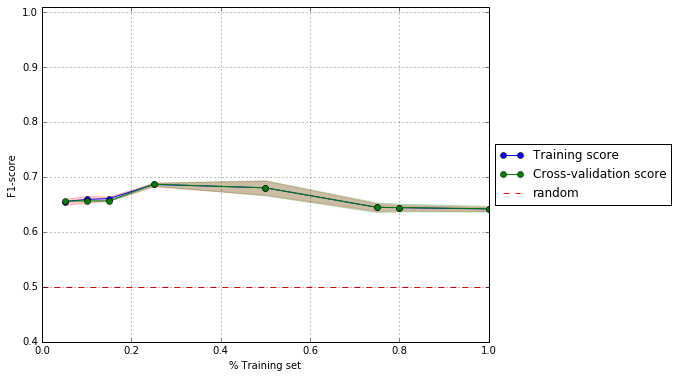

In [148]:
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
title = ""
plot_learning_curve(cls.best_estimator_, title, X_train, y_train, ylim=(0.4, 1.01), 
                    cv=cv_inner,
                    train_sizes=[0.05,0.10,0.15,0.25,0.50,0.75,0.80,1.0], 
                    n_jobs=-1)

plt.show()